In [16]:
import pandas as pd

def create_dataframe_from_csv(file_path):
    """
    Читает CSV-файл, устанавливает первую колонку как индекс DataFrame
    и преобразует ее в формат datetime. Обеспечивает формат, аналогичный
    DataFrame, возвращаемому функцией fetch_frame из src/data_loader.py,
    включая обработку дубликатов и заполнение пропущенных значений.
    """
    # Читаем CSV-файл, используя первую колонку как индекс и парся даты
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    # Проверяем, существует ли колонка 'common_delayp90'
    if 'common_delayp90' not in df.columns:
        raise ValueError("CSV-файл должен содержать колонку 'common_delayp90'.")

    # Преобразуем колонку 'common_delayp90' в числовой формат, как это делает fetch_frame
    df['common_delayp90'] = pd.to_numeric(df['common_delayp90'], errors='coerce')

    # Сортируем индекс, как это делает fetch_frame
    df = df.sort_index()

    # Явное удаление дубликатов по индексу, если они возникли
    # Это гарантирует, что каждая временная метка уникальна, как в fetch_frame
    if df.index.duplicated().any():
        df = df[~df.index.duplicated(keep='first')]

    # Применяем ffill с ограничением, как это делает fetch_frame
    df = df.ffill(limit=3)

    return df

csv_file = 'prometheus_forecast.csv'
df_forecast = create_dataframe_from_csv(csv_file)
print("DataFrame создан успешно:")
print(df_forecast)


DataFrame создан успешно:
                     common_delayp90
2025-05-13 11:41:15      2457.319174
2025-05-13 11:41:30      2695.726114
2025-05-13 11:41:45      2685.116737
2025-05-13 11:42:00      2645.169790
2025-05-13 11:42:15      2651.948648
2025-05-13 11:42:30      3183.774663
2025-05-13 11:42:45      3077.570876
2025-05-13 11:43:00      3172.274979
2025-05-13 11:43:15      2983.288124
2025-05-13 11:43:30      3044.014191
2025-05-13 11:43:45      2988.929124
2025-05-13 11:44:00      3021.617588
2025-05-13 11:44:15      3112.503176
2025-05-13 11:44:30      3000.339850
2025-05-13 11:44:45      3120.421202
2025-05-13 11:45:00      3001.348049
2025-05-13 11:45:15      3496.678744
2025-05-13 11:45:30      3493.304255
2025-05-13 11:45:45      3467.265310
2025-05-13 11:46:00      3196.747133
2025-05-13 11:46:15      3136.204557
2025-05-13 11:46:30      3019.103275
2025-05-13 11:46:45      3178.649694
2025-05-13 11:47:00      3462.204615
2025-05-13 11:47:15      3415.102108
2025-05-13 1

In [ ]:
from src.data_loader import fetch_frame
from ts_toolkit.io import clean_timeseries
# df = fetch_frame()
df = fetch_frame(
    use_cache=True,
    cache_filename="only_common_delayp90.parquet"
)

df = clean_timeseries(df, 'common_delay_p90')   # вместо блока 0‑3


In [18]:
df.tail()

,common_delayp90
2025-05-13 11:52:00,3312.741136
2025-05-13 11:52:15,3232.179903
2025-05-13 11:52:30,3219.900993
2025-05-13 11:52:45,3233.932358
2025-05-13 11:53:00,3248.542185


In [20]:
df_forecast.tail()

,common_delayp90
2025-05-13 11:52:00,3312.741136
2025-05-13 11:52:15,3232.179903
2025-05-13 11:52:30,3219.900993
2025-05-13 11:52:45,3233.932358
2025-05-13 11:53:00,3248.542185


In [22]:
df_true = df.loc[df_forecast.index]
df_true.head()

,common_delayp90
2025-05-13 11:41:15,2457.319174
2025-05-13 11:41:30,2695.726114
2025-05-13 11:41:45,2685.116737
2025-05-13 11:42:00,2645.169790
2025-05-13 11:42:15,2651.948648


In [24]:
# Подготавливаем данные для сравнения
pred_idx = df_forecast.index
y_true = df_true['common_delayp90'].reindex(df_forecast.index).dropna()
y_pred = df_forecast.reindex(y_true.index).dropna() # Убедимся, что все выровнено

print(f"Длина прогноза: {len(y_pred)}, Длина реальных данных: {len(y_true)}")

Длина прогноза: 48, Длина реальных данных: 48


Blind 24-h test • MAE=0.0  RMSE=0.0  MAPE=0.00%  on 48 valid points


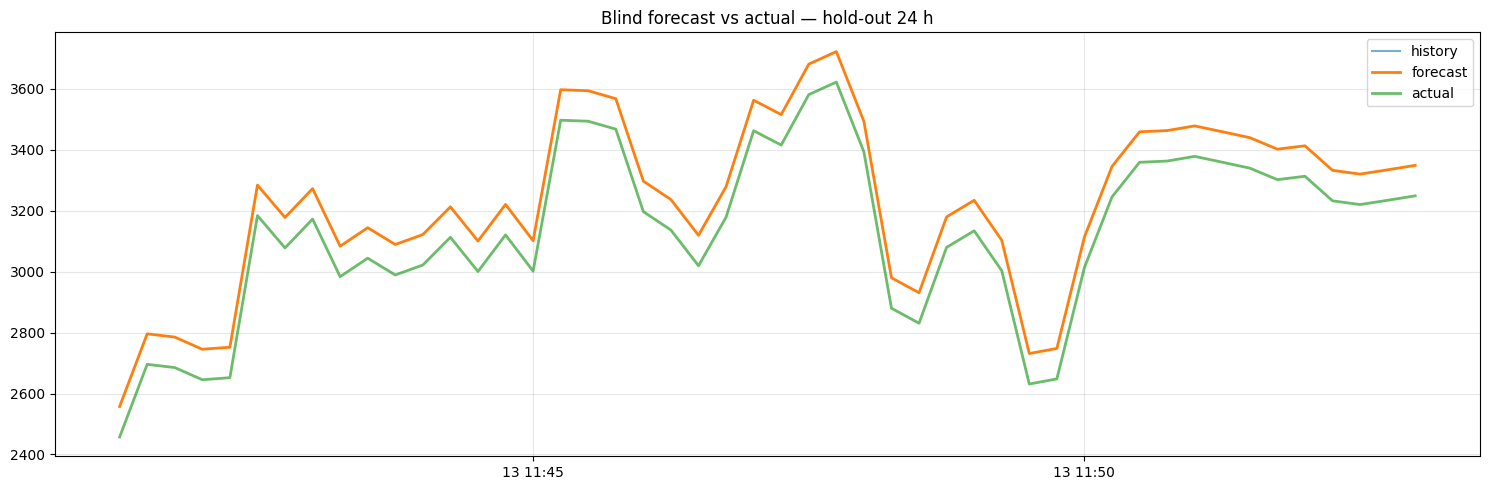

In [28]:
from ts_toolkit.metrics import global_metrics
from ts_toolkit.viz import plot_history_forecast
# y_true и y_pred уже созданы в предыдущей ячейке

metrics = global_metrics(y_true, y_pred)
print(f"Blind 24-h test • MAE={metrics['MAE']:.1f}  RMSE={metrics['RMSE']:.1f}  MAPE={metrics['MAPE']:.2f}%  "
      f"on {len(y_true)} valid points")

# ── график: история 3 сут + прогноз vs факт ──
# hist_start = pred_idx[0] - pd.Timedelta(hours=1)
hist_start = pred_idx[0] - pd.Timedelta(minutes=30)
plot_history_forecast(
    history  = df.loc[hist_start:pred_idx[0], 'common_delayp90'],
    forecast = df_forecast['common_delayp90']+100,
    actual   = y_true,
    title    = 'Blind forecast vs actual — hold-out 24 h'
)
